# Projects per platform exploration


##### Prerequiestes

In [1]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.window import Window

import schemas

timestamp_format = 'YYYY-MM-DD HH:mm:ss z'

def init_spark():
    spark = SparkSession.builder\
        .master('local[*]') \
        .appName('Libraries.io language exploration') \
        .config("spark.executor.memory", "8g") \
        .config("spark.driver.memory", "2g") \
        .config("spark.local.dir", "./tmp") \
        .getOrCreate()
    sc = spark.sparkContext
    return spark, sc

spark, sc = init_spark()

### Data extraction

Let's get the top 5 package managing platform s

In [2]:
projects = spark.read.csv(
    "data/projects-1.4.0-2018-12-22.csv", 
    header=True, 
    timestampFormat=timestamp_format,
    schema=schemas.projects
).fillna({'SourceRank': 0})

top_platforms = projects.select('Platform', 'Name') \
    .groupby('Platform') \
    .count() \
    .orderBy(desc('count')) \
    .limit(5)

top_platforms.toPandas()

,Platform,count
0,Go,1132134
1,NPM,926196
2,Packagist,251111
3,Maven,198088
4,Pypi,172411


Let's extract now the top projects per platform based on source rank provided by the dataset.

In [3]:
top_projects_per_platform = projects.select('Platform', 'Name', 'SourceRank') \
    .join(top_platforms, top_platforms['Platform'] == projects['Platform']) \
    .drop(projects['Platform']) \
    .drop(top_platforms['count']) \
    .orderBy(desc('SourceRank')) \
    .groupBy('Platform') \
    .agg(F.collect_list('Name')) \
    .rdd.map(list) \
    .map(lambda x: (x[0], x[1][:3])) \
    .collect()

top_projects_per_platform

[('Maven',
  ['org.apache.hbase:hbase',
   'com.spotify:styx-common',
   'com.spotify:styx-test']),
 ('NPM', ['nofactor', 'brain-games-by-peacelovecookies', 'extra-googletts']),
 ('Packagist', ['phpunit/phpunit', 'doctrine/orm', 'monolog/monolog']),
 ('Pypi', ['modelforge', 'requests', 'Django']),
 ('Go',
  ['github.com/docker/docker/pkg/mount',
   'github.com/Sirupsen/logrus',
   'github.com/docker/docker/utils'])]

In [4]:
data_frame_list = []
for x in top_projects_per_platform:
    for name in x[1]:
        row = projects.select('Platform','Name', 'SourceRank') \
            .where(projects['Name'] == name) \
            .where(projects['Platform'] == x[0]) \
            .toPandas()
        data_frame_list.append(row)
        
df = pd.concat(data_frame_list)
df

,Platform,Name,SourceRank
0,Maven,org.apache.hbase:hbase,237
0,Maven,com.spotify:styx-common,236
0,Maven,com.spotify:styx-test,202
0,NPM,nofactor,58
0,NPM,brain-games-by-peacelovecookies,48
0,NPM,extra-googletts,45
0,Packagist,phpunit/phpunit,31
0,Packagist,doctrine/orm,28
0,Packagist,monolog/monolog,28
0,Pypi,modelforge,33


### Plot the data now

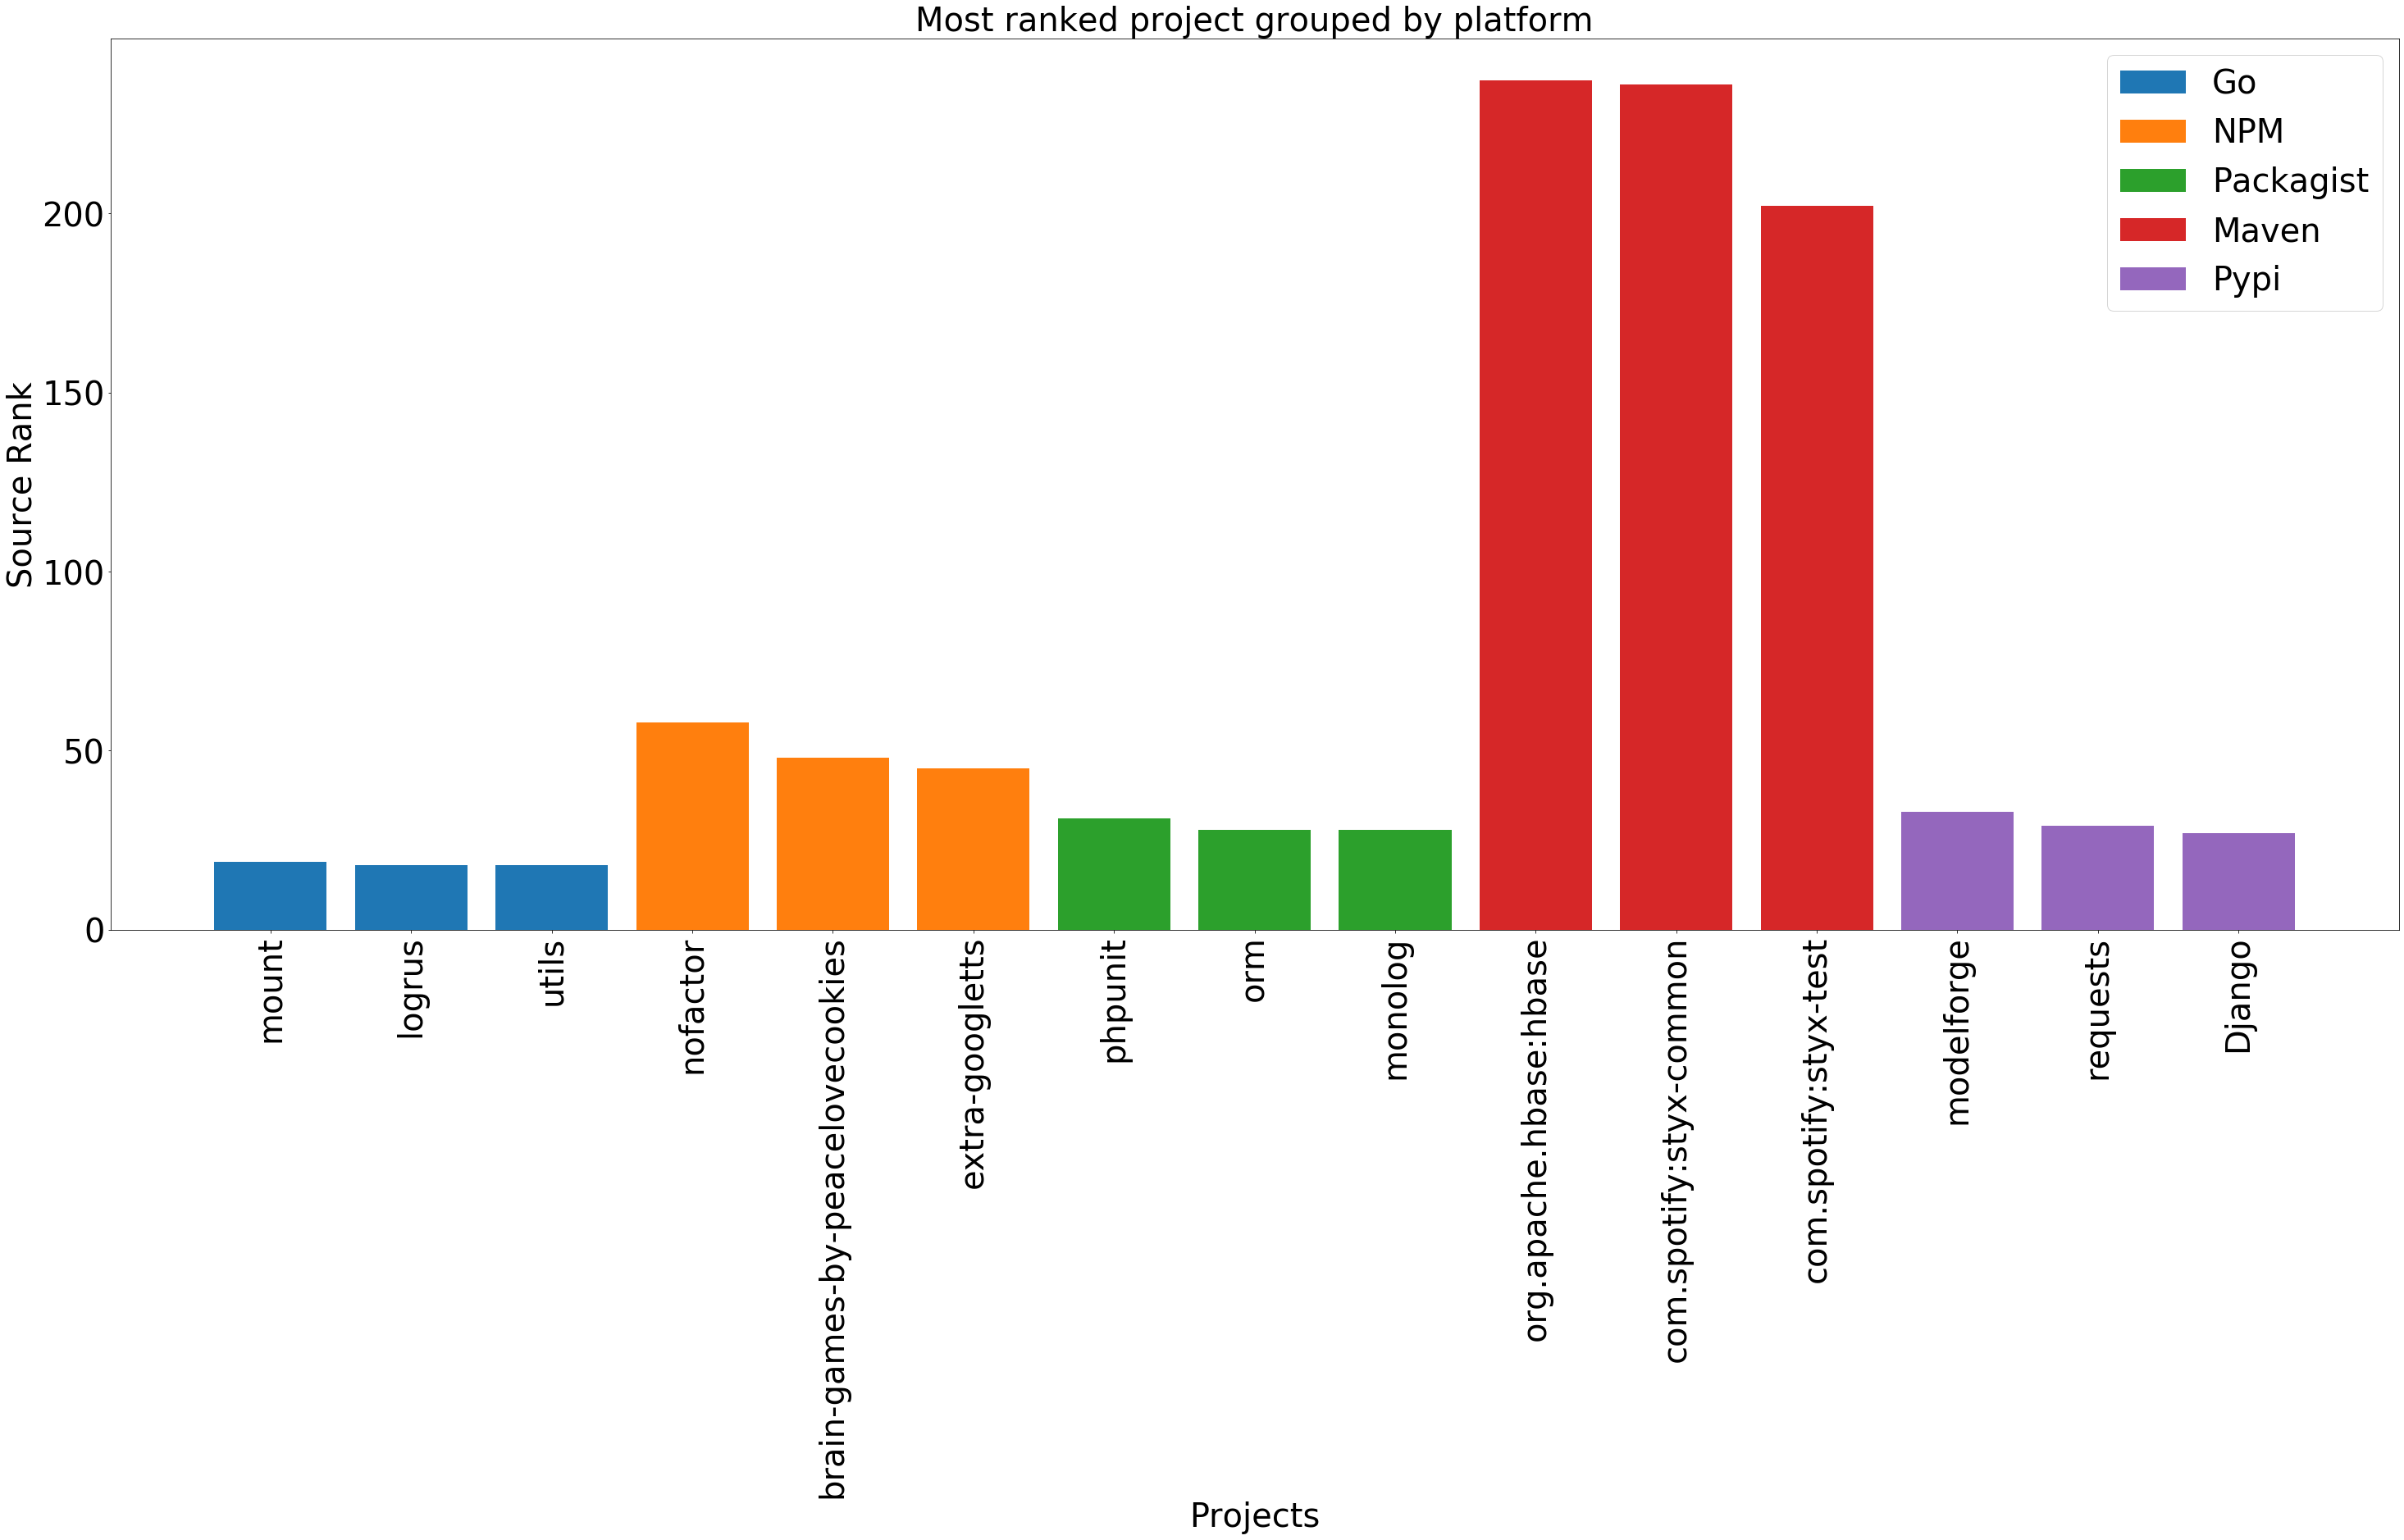

In [5]:
plt.figure(figsize=(50, 20))
for platform in top_platforms.select('Platform').rdd.map(list).collect():
    platform = platform[0]
    
    values = df.loc[df['Platform'] == platform]['SourceRank']
    names = df.loc[df['Platform'] == platform]['Name']
    names = [name.split("/")[-1] for name in names]
    
    plt.bar(names, values, label=platform)
    
plt.ylabel('Source Rank', fontsize=40)
plt.xlabel('Projects', fontsize=40)

plt.title("Most ranked project grouped by platform", fontsize=40)
    
plt.xticks(fontsize=40, rotation=90)
plt.yticks(fontsize=40)
plt.legend(prop={'size': 40})
plt.show()

    